In [1]:
import os
import torch
import params
# N = 6 # number of scales 

# K = 8 # number of orientations 

# imgSize = 256 # image size: retinal model require 256 

# nsmpl   = 11 

# model_name = 'retina-complexV1'
from PIL import Image
import math
import numpy as np 
import utilities as utils 

from models.retinalDN.retinalDN import RetinalDN
from models.steerable.steerable import SteerablePyramid

import models.steerable.steerableUtils as steer_utils

import matplotlib.pyplot as plt

import scipy.io as sio
import torch.nn as nn
import torch.nn.functional as F

In [4]:
imgNames = [ 'water', 'prairieTer', 'boats', 'ice3', 'dogville', 'egomotion', 'walking', 'smile', 
            'bees', 'leaves-wind', 'carnegie-dam', 'chironomus' ]
loaddir = 'models/retinalDN/'
filters_LGN = sio.loadmat(loaddir + 'filters.mat')
params_LGN  = sio.loadmat(loaddir +  'params.mat')
filters_LGN = torch.Tensor( filters_LGN['filters'] ) # (3, 31, 31)
params_LGN  = torch.Tensor(  params_LGN['params' ] ).squeeze() # (2, )

kerSize = filters_LGN.size(-1)
pad = (kerSize-1)//2
pad = (pad, pad, pad, pad)
linConv = nn.Conv2d( 1, 1, kerSize, bias=False )
lumConv = nn.Conv2d( 1, 1, kerSize, bias=False )
conConv = nn.Conv2d( 1, 1, kerSize, bias=False ) 
linConv.weight.data.copy_( filters_LGN[0] ) 
lumConv.weight.data.copy_( filters_LGN[1] ) 
conConv.weight.data.copy_( filters_LGN[2] )
softplus = nn.Softplus()

curv_LGN = {}
# curv_LGN['pixel'] = {}

for i, imgName in enumerate(imgNames):
    output = {}
    x = utils.makeGroundtruth(imgName)
    output['000'] = x
    
    x = x.unsqueeze(1) # (11, 1, 256, 256)
    xpad = F.pad( x, pad, mode='replicate' )
    xN = x / (1 + params_LGN[0]*lumConv(xpad))
    output['010'] = xN
    
    c1 = F.pad(xN**2, pad, mode='replicate')
    c1 = (conConv(c1) + 1e-6).sqrt()
    xNn = xN / (1 + params_LGN[1]*c1)
    output['011'] = xNn
    
    c2 = (conConv(xpad**2) + 1e-6).sqrt()
    xn = x / (1 + params_LGN[1]*c2)
    output['001'] = xn
    
    xF = linConv( xpad )
    output['100'] = xF
    xFN = xF / (1 + params_LGN[0]*lumConv(xpad))
    output['110'] = xFN
    c = F.pad(xFN**2, pad, mode='replicate')
    c = (conConv(c) + 1e-6).sqrt()
    xFNn = xFN / (1 + params_LGN[1]*c)
    output['111'] = xFNn

    c3 = F.pad(xF**2, pad, mode='replicate')
    c3 = (conConv(c3) + 1e-6).sqrt()
    xFn = xF / (1 + params_LGN[1]*c3)
    output['101'] = xFn
    
    for key in list(output):
        dY, cY = utils.computeDistCurv( softplus(output[key]) )
        if key not in list(curv_LGN):
            curv_LGN[key] = {}
        curv_LGN[key][imgName] = cY.data.mean()
    
#     dY, cY = utils.computeDistCurv( output['000'])
#     curv_LGN['pixel'][imgName] = cY.data.mean()
        
for key in list(curv_LGN):
    curv_LGN[key]['mean'] = np.array(list(curv_LGN[key].values())).mean()

([<matplotlib.axis.XTick at 0x14606bf45820>,
 [Text(0, 0, 'pixel'),
  Text(1, 0, 'N1'),
  Text(2, 0, 'N1N2'),
  Text(3, 0, 'N2'),
  Text(4, 0, 'F'),
  Text(5, 0, 'FN1'),
  Text(6, 0, 'FN1N2'),
  Text(7, 0, 'FN2')])

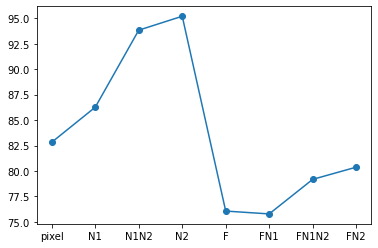

In [5]:
# compare and plot the curvature
a = np.empty(len(list(curv_LGN)))
for i, key in enumerate(list(curv_LGN)):
    a[i] = curv_LGN[key]['mean']
    
plt.plot(a, '-o')
LGN_label = ['pixel', 'N1', 'N1N2', 'N2', 'F', 'FN1', 'FN1N2', 'FN2']
plt.xticks(np.arange(len(list(curv_LGN))), list(LGN_label))

tensor([1.7144, 5.8337])
tensor(0.8874) tensor(-0.0094)
tensor(0.0009) tensor(0.0002)
tensor(0.0599) tensor(1.0411e-38)


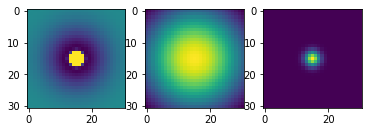

In [9]:
loaddir = 'models/retinalDN/'
filters = sio.loadmat(loaddir + 'filters.mat')
params  = sio.loadmat(loaddir +  'params.mat')

filters = torch.Tensor( filters['filters'] ) # (3, 31, 31)

params  = torch.Tensor(  params['params' ] ).squeeze() # (2, )
print(params)

plt.figure()
for i in range(3):
    plt.subplot(1,3,i+1)
    if i == 0:
        plt.imshow(filters[i], vmax=0.01)
    else:
        plt.imshow(filters[i])
    print(torch.max(filters[i]), torch.min(filters[i]))

tensor(3.8917) tensor(0.0122)
tensor(3792814.) tensor(0.9675)


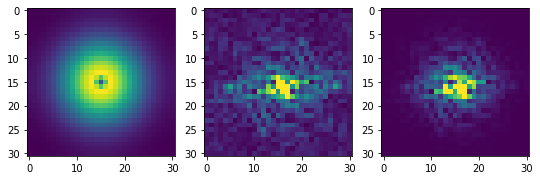

In [14]:
# compare the frequency components of the LGN filter and the images
def norm(c):
    # norm of a complex tensor
    return torch.sqrt(torch.real(c * c.conj()))

def crop(img, size):
    old_size = img.size()[0]
    a = int((old_size - size) / 2.0)
    return img[a:a+size, a:a+size]

def imshow(img, rank=10):
    vmax = torch.sort(torch.flatten(img))[0][-rank]
    plt.imshow(img, vmax=vmax)

plt.figure(figsize=(9,20))
freq_filter = torch.fft.fft2(filters[0]) # (31, 31)
filter_norm = norm(freq_filter)
print(torch.max(filter_norm), torch.min(filter_norm))
plt.subplot(131)
plt.imshow(torch.fft.fftshift(filter_norm))

freq_img = torch.fft.fft2(x[0]).squeeze(0)
img_norm = norm(freq_img)
print(torch.max(img_norm), torch.min(img_norm))
plt.subplot(132)
imshow(crop(torch.fft.fftshift(img_norm), 31))

plt.subplot(133)
imshow(crop(torch.fft.fftshift(img_norm), 31) * torch.fft.fftshift(filter_norm))

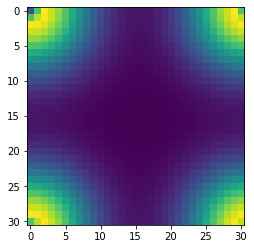

In [16]:
# expand or shrink the 2D frequency plot

plt.imshow(filter_norm)

def reform_corner(freq_filter, move=0): # only apply to filters of odd sizes, square
    s = freq_filter.size(0)
    new_freq_filter = torch.empty((s, s))
    value = list(torch.diagonal(s)) + list(s[0][1:])
    value = torch.sort(torch.tensor(value))

In [19]:
filter_back = torch.fft.irfft2(freq_filter, s=(freq_filter.size(0), freq_filter.size(0)))

torch.Size([31, 31])


In [ ]:
# apply the new filter to see how curvature changes